# Quick train SBI
Then save the posterior as a pkl using the evaluate module. This notebook demonstrates how to run SBI using the 'on the fly' technique, where SBI uses the prior and simulator to generate data as it trains. An alternate method (that is adventageous for expensive data generation) is demonstrated in the `save_and_load_data.ipynb` tutorial, where the data is pre-generated and used to train SBI.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# remove top and right axis from plots
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False

In [2]:
import sbi
from sbi.inference import SNPE
from sbi.inference.base import infer
from sbi.analysis import pairplot
import torch

In [3]:
# this is necessary to import modules from this repo
import sys
sys.path.append('..')
from src.scripts import io

In [4]:
def simulator(thetas):#, percent_errors):
    # just plop the pendulum within here
    m, b = thetas
    x = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    # I'm thinking sigma could actually be a function of x
    # if we want to get fancy down the road
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size = len(x)) 
    return m * x + b + ε

In [5]:
num_dim = 2

low_bounds = torch.tensor([0, -10])
high_bounds = torch.tensor([10, 10])

prior = sbi.utils.BoxUniform(low = low_bounds, high = high_bounds)

In [6]:
posterior = infer(simulator, prior, "SNPE", num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 92 epochs.

In [8]:
modelloader = io.ModelLoader()
path = "../savedmodels/sbi/"
model_name = "sbi_linear_generative"
modelloader.save_model_pkl(path, model_name, posterior)

Test that this worked.

In [9]:
path = "../savedmodels/sbi/"
model_name = "sbi_linear_generative"
posterior = modelloader.load_model_pkl(path, model_name)

../savedmodels/sbi/


Run inference on the posterior.

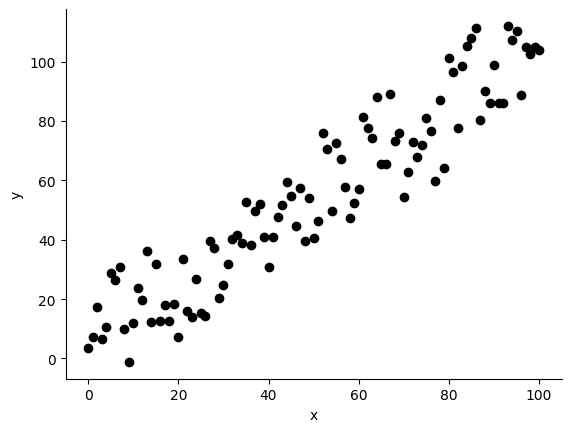

In [10]:
# generate a true dataset
theta_true = [1, 5]
y_true = simulator(theta_true)

# and visualize it
plt.clf()
plt.scatter(np.linspace(0, 100, 101),
            np.array(y_true), color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

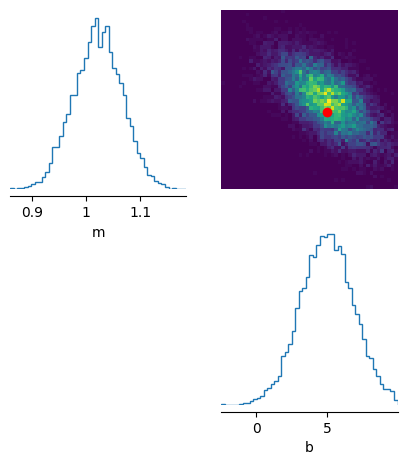

In [11]:
# sample from the posterior
posterior_samples_1 = posterior.sample((10000,), x = y_true)
# that last little part is conditioning on a data value
# plot posterior samples
fig, axes = sbi.analysis.pairplot(
    posterior_samples_1, 
    labels = ['m', 'b'],
    #limits = [[0,10],[-10,10],[0,10]],
    truths = theta_true,
    figsize=(5, 5)
)
axes[0, 1].plot([theta_true[1]], [theta_true[0]], marker="o", color="red")